# Tutorial on GraphNN

We try to build a GraphNN that recognize if an image contains a rectangle or a circle, representing the image as a point cloud

In [ ]:
#from https://github.com/vermaMachineLearning/keras-deep-graph-learning.git
import tensorflow.keras.backend as K
import tensorflow as tf


def graph_conv_op(x, num_filters, graph_conv_filters, kernel):

    if len(x.get_shape()) == 2:
        conv_op = K.dot(graph_conv_filters, x)
        conv_op = tf.split(conv_op, num_filters, axis=0)
        conv_op = K.concatenate(conv_op, axis=1)
    elif len(x.get_shape()) == 3:
        conv_op = K.batch_dot(graph_conv_filters, x)
        conv_op = tf.split(conv_op, num_filters, axis=1)
        conv_op = K.concatenate(conv_op, axis=2)
    else:
        raise ValueError('x must be either 2 or 3 dimension tensor'
                         'Got input shape: ' + str(x.get_shape()))

    conv_out = K.dot(conv_op, kernel)
    return conv_out

from tensorflow.keras import activations, initializers, constraints
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer
import tensorflow as tf

class MultiGraphCNN(Layer):

    def __init__(self,
                 output_dim,
                 num_filters,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(MultiGraphCNN, self).__init__(**kwargs)

        self.output_dim = output_dim
        self.num_filters = num_filters

        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_initializer.__name__ = kernel_initializer
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

    def build(self, input_shape):

        if self.num_filters != int(input_shape[1][-2]/input_shape[1][-1]):
            raise ValueError('num_filters does not match with graph_conv_filters dimensions.')

        self.input_dim = input_shape[0][-1]
        kernel_shape = (self.num_filters * self.input_dim, self.output_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.output_dim,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.built = True

    def call(self, inputs):

        output = graph_conv_op(inputs[0], self.num_filters, inputs[1], self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = (input_shape[0][0], input_shape[0][1], self.output_dim)
        return output_shape

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'num_filters': self.num_filters,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(MultiGraphCNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Import useful stuff

In [2]:
import numpy as np
from math import *
from matplotlib import pyplot as plt 
#device_name = tf.test.gpu_device_name()
#print(device_name)

# Load the dataset

In [ ]:
!git clone https://github.com/pierinim/tutorials.git
!mv tutorials/GNN_Pisa_Nov2021/data .

In [3]:
# load one file
import h5py
f = h5py.File("data/ShapeClassifier_Circle0.9_Noise0.3.h5", "r")
#f = h5py.File("data/ShapeClassifier_Circle0.9_Rectangle0.7.h5", "r")
X_train = np.array(f.get("X_train"))
X_test = np.array(f.get("X_test"))
Y_train = np.array(f.get("Y_train"))
Y_test = np.array(f.get("Y_test"))
A_train = np.array(f.get("A_train"))
A_test = np.array(f.get("A_test"))
f.close()    

In [4]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)
print(A_train.shape, A_test.shape)

(700, 100, 3) (300, 100, 3)
(700,) (300,)
(700, 100, 100) (300, 100, 100)


# Now we define the Classifier
We use an implementation of Graph Convolutional Layers, distributed with
https://vermamachinelearning.github.io/keras-deep-graph-learning/

In [21]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Dropout,Flatten,Reshape
from tensorflow.keras.models import Model, Sequential
    
NUM_FILTERS = 1
graph_conv_filters = A_train 
graph_conv_filters = K.constant(graph_conv_filters)
    
X_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))
    
hidden =  MultiGraphCNN(2, NUM_FILTERS, activation='relu')([X_input,graph_conv_filters_input])
hidden = Dropout(0.4)(hidden)
hidden =  MultiGraphCNN(1, NUM_FILTERS, activation='relu')([hidden,graph_conv_filters_input])
hidden = Dropout(0.4)(hidden)
hidden = Flatten()(hidden)
output = Dense(1, activation='sigmoid')(hidden)
loss="binary_crossentropy"
model = Model(inputs=[X_input,graph_conv_filters_input], outputs=output)
model.compile(loss=loss, optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
multi_graph_cnn_6 (MultiGraphCN (None, 100, 2)       8           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 100, 2)       0           multi_graph_cnn_6[0][0]    

In [22]:
history = model.fit([X_train, graph_conv_filters],Y_train,validation_split=0.3, batch_size=16, epochs=400, verbose=1)

Epoch 1/400
31/31 [==============================] - 1s 7ms/step - loss: 19.6669 - accuracy: 0.5054 - val_loss: 5.4303 - val_accuracy: 0.4834
Epoch 2/400
31/31 [==============================] - 0s 3ms/step - loss: 15.9321 - accuracy: 0.5192 - val_loss: 5.3024 - val_accuracy: 0.4028
Epoch 3/400
31/31 [==============================] - 0s 3ms/step - loss: 13.2120 - accuracy: 0.5160 - val_loss: 4.2127 - val_accuracy: 0.4692
Epoch 4/400
31/31 [==============================] - 0s 3ms/step - loss: 14.8158 - accuracy: 0.4600 - val_loss: 3.6888 - val_accuracy: 0.4550
Epoch 5/400
31/31 [==============================] - 0s 3ms/step - loss: 10.4378 - accuracy: 0.5183 - val_loss: 3.7129 - val_accuracy: 0.4171
Epoch 6/400
31/31 [==============================] - 0s 3ms/step - loss: 10.4662 - accuracy: 0.5018 - val_loss: 3.0166 - val_accuracy: 0.4597
Epoch 7/400
31/31 [==============================] - 0s 3ms/step - loss: 8.2128 - accuracy: 0.4965 - val_loss: 2.9851 - val_accuracy: 0.4929
Epoch 8

Epoch 59/400
31/31 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.7770 - val_loss: 0.5806 - val_accuracy: 0.8294
Epoch 60/400
31/31 [==============================] - 0s 2ms/step - loss: 0.6052 - accuracy: 0.7468 - val_loss: 0.5777 - val_accuracy: 0.8436
Epoch 61/400
31/31 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.7903 - val_loss: 0.5769 - val_accuracy: 0.8436
Epoch 62/400
31/31 [==============================] - 0s 2ms/step - loss: 0.5997 - accuracy: 0.7863 - val_loss: 0.5738 - val_accuracy: 0.8626
Epoch 63/400
31/31 [==============================] - 0s 2ms/step - loss: 0.5667 - accuracy: 0.8200 - val_loss: 0.5722 - val_accuracy: 0.8673
Epoch 64/400
31/31 [==============================] - 0s 2ms/step - loss: 0.6114 - accuracy: 0.8259 - val_loss: 0.5685 - val_accuracy: 0.8626
Epoch 65/400
31/31 [==============================] - 0s 2ms/step - loss: 0.6136 - accuracy: 0.8118 - val_loss: 0.5698 - val_accuracy: 0.8673
Epoch 

31/31 [==============================] - 0s 2ms/step - loss: 0.4635 - accuracy: 0.8408 - val_loss: 0.4471 - val_accuracy: 0.9336
Epoch 117/400
31/31 [==============================] - 0s 2ms/step - loss: 0.4987 - accuracy: 0.8723 - val_loss: 0.4465 - val_accuracy: 0.9289
Epoch 118/400
31/31 [==============================] - 0s 2ms/step - loss: 0.4849 - accuracy: 0.8665 - val_loss: 0.4410 - val_accuracy: 0.9336
Epoch 119/400
31/31 [==============================] - 0s 2ms/step - loss: 0.4260 - accuracy: 0.8846 - val_loss: 0.4324 - val_accuracy: 0.9384
Epoch 120/400
31/31 [==============================] - 0s 2ms/step - loss: 0.4552 - accuracy: 0.8817 - val_loss: 0.4278 - val_accuracy: 0.9384
Epoch 121/400
31/31 [==============================] - 0s 2ms/step - loss: 0.4806 - accuracy: 0.8645 - val_loss: 0.4251 - val_accuracy: 0.9431
Epoch 122/400
31/31 [==============================] - 0s 2ms/step - loss: 0.4133 - accuracy: 0.9047 - val_loss: 0.4209 - val_accuracy: 0.9431
Epoch 123/400

31/31 [==============================] - 0s 2ms/step - loss: 0.3527 - accuracy: 0.8534 - val_loss: 0.2800 - val_accuracy: 0.9716
Epoch 174/400
31/31 [==============================] - 0s 2ms/step - loss: 0.2847 - accuracy: 0.9192 - val_loss: 0.2796 - val_accuracy: 0.9668
Epoch 175/400
31/31 [==============================] - 0s 2ms/step - loss: 0.3391 - accuracy: 0.8915 - val_loss: 0.2807 - val_accuracy: 0.9668
Epoch 176/400
31/31 [==============================] - 0s 2ms/step - loss: 0.3167 - accuracy: 0.9246 - val_loss: 0.2760 - val_accuracy: 0.9716
Epoch 177/400
31/31 [==============================] - 0s 2ms/step - loss: 0.3599 - accuracy: 0.8646 - val_loss: 0.2760 - val_accuracy: 0.9716
Epoch 178/400
31/31 [==============================] - 0s 2ms/step - loss: 0.2810 - accuracy: 0.9146 - val_loss: 0.2675 - val_accuracy: 0.9763
Epoch 179/400
31/31 [==============================] - 0s 2ms/step - loss: 0.3109 - accuracy: 0.9144 - val_loss: 0.2735 - val_accuracy: 0.9716
Epoch 180/400

31/31 [==============================] - 0s 2ms/step - loss: 0.3009 - accuracy: 0.8972 - val_loss: 0.2040 - val_accuracy: 0.9763
Epoch 231/400
31/31 [==============================] - 0s 2ms/step - loss: 0.2515 - accuracy: 0.9275 - val_loss: 0.2045 - val_accuracy: 0.9716
Epoch 232/400
31/31 [==============================] - 0s 5ms/step - loss: 0.2859 - accuracy: 0.8887 - val_loss: 0.2018 - val_accuracy: 0.9763
Epoch 233/400
31/31 [==============================] - 0s 3ms/step - loss: 0.2552 - accuracy: 0.9099 - val_loss: 0.2002 - val_accuracy: 0.9763
Epoch 234/400
31/31 [==============================] - 0s 3ms/step - loss: 0.2920 - accuracy: 0.9099 - val_loss: 0.1991 - val_accuracy: 0.9763
Epoch 235/400
31/31 [==============================] - 0s 3ms/step - loss: 0.2707 - accuracy: 0.8837 - val_loss: 0.1991 - val_accuracy: 0.9763
Epoch 236/400
31/31 [==============================] - 0s 3ms/step - loss: 0.2544 - accuracy: 0.9153 - val_loss: 0.1991 - val_accuracy: 0.9763
Epoch 237/400

31/31 [==============================] - 0s 3ms/step - loss: 0.2450 - accuracy: 0.9032 - val_loss: 0.1744 - val_accuracy: 0.9763
Epoch 288/400
31/31 [==============================] - 0s 3ms/step - loss: 0.2240 - accuracy: 0.9180 - val_loss: 0.1740 - val_accuracy: 0.9716
Epoch 289/400
31/31 [==============================] - 0s 3ms/step - loss: 0.3063 - accuracy: 0.8866 - val_loss: 0.1740 - val_accuracy: 0.9763
Epoch 290/400
31/31 [==============================] - 0s 3ms/step - loss: 0.2422 - accuracy: 0.9129 - val_loss: 0.1736 - val_accuracy: 0.9716
Epoch 291/400
31/31 [==============================] - 0s 3ms/step - loss: 0.3022 - accuracy: 0.8924 - val_loss: 0.1754 - val_accuracy: 0.9716
Epoch 292/400
31/31 [==============================] - 0s 3ms/step - loss: 0.2517 - accuracy: 0.9032 - val_loss: 0.1724 - val_accuracy: 0.9716
Epoch 293/400
31/31 [==============================] - 0s 3ms/step - loss: 0.2567 - accuracy: 0.8965 - val_loss: 0.1726 - val_accuracy: 0.9716
Epoch 294/400

31/31 [==============================] - 0s 2ms/step - loss: 0.3003 - accuracy: 0.8798 - val_loss: 0.1610 - val_accuracy: 0.9716
Epoch 345/400
31/31 [==============================] - 0s 2ms/step - loss: 0.2760 - accuracy: 0.8806 - val_loss: 0.1613 - val_accuracy: 0.9716
Epoch 346/400
31/31 [==============================] - 0s 2ms/step - loss: 0.2948 - accuracy: 0.8834 - val_loss: 0.1625 - val_accuracy: 0.9716
Epoch 347/400
31/31 [==============================] - 0s 2ms/step - loss: 0.2698 - accuracy: 0.8869 - val_loss: 0.1619 - val_accuracy: 0.9716
Epoch 348/400
31/31 [==============================] - 0s 2ms/step - loss: 0.2384 - accuracy: 0.9158 - val_loss: 0.1620 - val_accuracy: 0.9716
Epoch 349/400
31/31 [==============================] - 0s 2ms/step - loss: 0.2608 - accuracy: 0.8999 - val_loss: 0.1626 - val_accuracy: 0.9763
Epoch 350/400
31/31 [==============================] - 0s 2ms/step - loss: 0.2758 - accuracy: 0.8865 - val_loss: 0.1612 - val_accuracy: 0.9716
Epoch 351/400

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


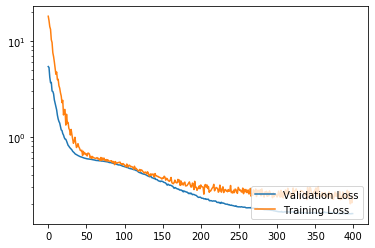

In [23]:
print(history.history.keys())
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot(history.history["loss"], label="Training Loss")
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()

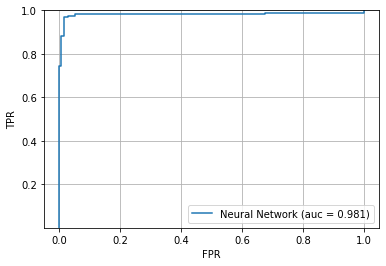

In [24]:
from sklearn.metrics import roc_curve, auc

graph_conv_filters = A_test 
graph_conv_filters = K.constant(graph_conv_filters)
Y_pred = model.predict([X_test, graph_conv_filters])

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(Y_test, Y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, label='Neural Network (auc = %0.3f)' % auc_keras)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()